### Computing adjacency matrix

We would like to define the edge structure of our graph GNN using an adjacency matrix, which can either be learned or estimated using a correlation matrix between all the observed SST gridpoints. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe

In [2]:
hadsst = xr.open_dataset("/gws/nopw/j04/aopp/andreww/CPDN/data/HadISST_sst.nc")['sst'].rename({'latitude':'lat', 'longitude':'lon'})

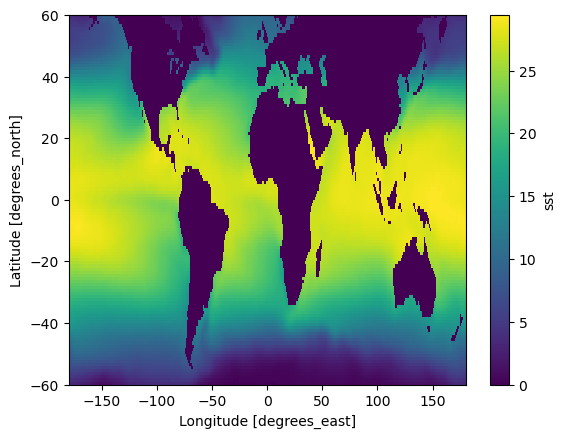

In [4]:
hadsst_zero = hadsst.where(hadsst>0,0)
hadsst_annual_mean = hadsst_zero.sel(lat=slice(60, -60)).resample(time='1Y').mean('time')
hadsst_annual_mean.mean('time').plot()

Let's regrid to a manageable number of nodes (gridpoints), say 5deg by 5deg.

In [5]:
dlon, dlat = 5., 5.

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-60.+dlat/2., 60., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

def regrid_to_common(ds, ds_out=ds_out, save_weights=False):
    """
    Regrid from rectilinear grid to common grid
    
    Bilinear and conservative should be the most commonly used methods. 
    They are both monotonic (i.e. will not create new maximum/minimum). 
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, reuse_weights=save_weights)
    return regridder(ds)

In [6]:
hadsst_regridded = regrid_to_common(hadsst_annual_mean)

/home/users/jwang28/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


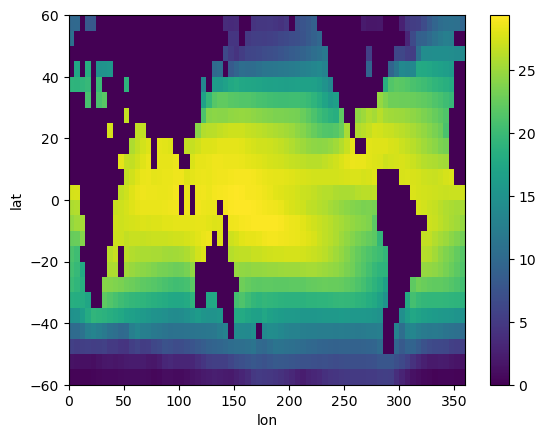

In [7]:
hadsst_regridded.mean('time').plot()

We have N = 24 x 72 = 1728 gridpoints. The adjacency matrix in our case is therefore N x N.

We can calculate an 'aggregated' adjacency matrix by computing the correlation matrix at each time step, and taking the element-wise mean.

In [23]:
hadsst_regridded

<xarray.DataArray (time: 149, lat: 24, lon: 72)>
array([[[ 0.18795258,  0.17898993,  0.1848979 , ...,  0.24671526,
          0.24274226,  0.22796471],
        [ 1.0194992 ,  0.93210334,  0.76729923, ...,  1.5381812 ,
          1.2053933 ,  1.0659131 ],
        [ 4.982658  ,  4.6236463 ,  4.693417  , ...,  5.335942  ,
          5.028805  ,  5.1401124 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 14.200494  ,
         14.071664  , 13.877464  ],
        [10.483411  ,  0.        ,  0.        , ..., 12.473901  ,
          0.        ,  0.        ],
        [ 9.699405  ,  9.638848  ,  0.        , ..., 11.12003   ,
         10.734628  ,  9.632816  ]],

       [[ 0.20345552,  0.2054292 ,  0.21984768, ...,  0.2589988 ,
          0.25508502,  0.24183778],
        [ 1.0751005 ,  1.0106905 ,  0.8608919 , ...,  1.5433384 ,
          1.2183334 ,  1.1002935 ],
        [ 5.0252414 ,  4.7311206 ,  4.8904757 , ...,  5.226047  ,
          4.9394717 ,  5.1152053 ],
...
        [ 0.        ,  0.        ,  0.        , ..., 14.824933  ,
         14.841048  , 14.736154  ],
        [12.371708  ,  0.        ,  0.        , ..., 12.828656  ,
          0.        ,  0.        ],
        [10.6711035 , 11.062949  ,  0.        , ..., 11.398449  ,
         11.257318  , 10.383504  ]],

       [[ 0.36957747,  0.3149166 ,  0.3844398 , ...,  0.6032778 ,
          0.51411134,  0.3698454 ],
        [ 1.9451532 ,  1.8967053 ,  1.6308279 , ...,  2.3574815 ,
          2.1567023 ,  2.112361  ],
        [ 6.472907  ,  5.851552  ,  6.068625  , ...,  6.262748  ,
          6.0856624 ,  6.2892776 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 14.809712  ,
         14.956059  , 14.89934   ],
        [12.388028  ,  0.        ,  0.        , ..., 12.84656   ,
          0.        ,  0.        ],
        [10.842346  , 11.2070675 ,  0.        , ..., 11.05218   ,
         10.967787  , 10.248934  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1870-12-31 1871-12-31 ... 2018-12-31
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    regrid_method:  bilinear

In [8]:
hadsst_regridded[0]

<xarray.DataArray (lat: 24, lon: 72)>
array([[ 0.18795258,  0.17898993,  0.1848979 , ...,  0.24671526,
         0.24274226,  0.22796471],
       [ 1.0194992 ,  0.93210334,  0.76729923, ...,  1.5381812 ,
         1.2053933 ,  1.0659131 ],
       [ 4.982658  ,  4.6236463 ,  4.693417  , ...,  5.335942  ,
         5.028805  ,  5.1401124 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 14.200494  ,
        14.071664  , 13.877464  ],
       [10.483411  ,  0.        ,  0.        , ..., 12.473901  ,
         0.        ,  0.        ],
       [ 9.699405  ,  9.638848  ,  0.        , ..., 11.12003   ,
        10.734628  ,  9.632816  ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1870-12-31
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    regrid_method:  bilinear

x is a 2-D array containing multiple variables and observations. Each row of x represents a variable, and each column a single observation of all those variables. 

- Each row = gridpoint
- Each column = given year

In [9]:
N_gridpoints = len(hadsst_regridded.lat.values)*len(hadsst_regridded.lon.values)
N_timesteps = len(hadsst_regridded.time.values)

x = np.zeros((N_gridpoints, N_timesteps))

In [10]:
x.shape

(1728, 149)

In [11]:
row_number = 0
for lat in hadsst_regridded.lat.values:
    for lon in hadsst_regridded.lon.values:
        x[row_number,:] = hadsst_regridded.sel(lat=lat, lon=lon).values
        row_number += 1

In [12]:
A = np.corrcoef(x)

/home/users/jwang28/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/users/jwang28/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: the first row of the adjacency matrix represents the gridpoint (-57.5, 2.5). Then we loop through the longitudes before moving to the next latitude, ans so on.

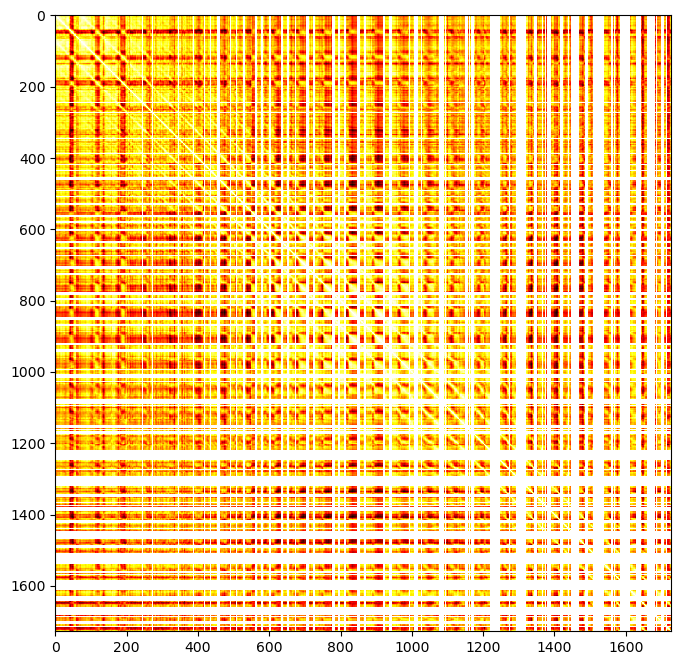

In [13]:
fig = plt.figure(figsize=(15,8))
plt.imshow(A, cmap='hot', interpolation='nearest')

In [19]:
np.save('adjacency_5deg.npy', A)